<a href="https://colab.research.google.com/github/raynardj/python4ml/blob/master/experiments/example_of_vqvae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## VQ-VAE training example
 
 The code is from [this research notebook from google](https://github.com/rosinality/vq-vae-2-pytorch/blob/master/vqvae.py)
 
Demonstration of how to train the model specified in [this paper](https://arxiv.org/abs/1711.00937)

On Mac and Linux, simply execute each cell in turn.

In [1]:
from __future__ import print_function

import os
import subprocess
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import sonnet as snt
import tensorflow as tf
import tarfile

from six.moves import cPickle
from six.moves import urllib
from six.moves import xrange

W0701 02:04:49.227719 140267863771008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/sonnet/python/custom_getters/restore_initializer.py:27: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0701 02:04:51.711639 140267863771008 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### Download Cifar10 data
This requires a connection to the internet and will download ~160MB.

In [2]:
data_path = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

local_data_dir = tempfile.mkdtemp()  # Change this as needed
tf.gfile.MakeDirs(local_data_dir)

url = urllib.request.urlopen(data_path)
archive = tarfile.open(fileobj=url, mode='r|gz') # read a .tar.gz stream
archive.extractall(local_data_dir)
url.close()
archive.close()
print('extracted data files to %s' % local_data_dir)

extracted data files to /tmp/tmp4kuf71yg



### Load the data into Numpy
We compute the variance of the whole training set to normalise the Mean Squared Error below.

In [0]:
def unpickle(filename):
  with open(filename, 'rb') as fo:
    return cPickle.load(fo, encoding='latin1')
  
def reshape_flattened_image_batch(flat_image_batch):
    """
    reshape and transpose to channel last, numpy array operation
    """
    return flat_image_batch.reshape(-1, 3, 32, 32).transpose([0, 2, 3, 1])  # convert from NCHW to NHWC

def combine_batches(batch_list):
  images = np.vstack([reshape_flattened_image_batch(batch['data'])
                      for batch in batch_list])
  labels = np.vstack([np.array(batch['labels']) for batch in batch_list]).reshape(-1, 1)
  return {'images': images, 'labels': labels}
  

train_data_dict = combine_batches([
    unpickle(os.path.join(local_data_dir,
                          'cifar-10-batches-py/data_batch_%d' % i))
    for i in range(1,5)
])

valid_data_dict = combine_batches([
    unpickle(os.path.join(local_data_dir,
                          'cifar-10-batches-py/data_batch_5'))])

test_data_dict = combine_batches([
    unpickle(os.path.join(local_data_dir, 'cifar-10-batches-py/test_batch'))])

In [0]:
def cast_and_normalise_images(data_dict):
  """Convert images to floating point with the range [0.5, 0.5]"""
  images = data_dict['images']
  data_dict['images'] = (tf.cast(images, tf.float32) / 255.0) - 0.5
  return data_dict

data_variance = np.var(train_data_dict['images'] / 255.0)

### Encoder & Decoder Architecture

In [0]:
def residual_stack(h, num_hiddens, num_residual_layers, num_residual_hiddens):
  for i in range(num_residual_layers):
    h_i = tf.nn.relu(h)

    h_i = snt.Conv2D(
        output_channels=num_residual_hiddens,
        kernel_shape=(3, 3),
        stride=(1, 1),
        name="res3x3_%d" % i)(h_i)
    h_i = tf.nn.relu(h_i)

    h_i = snt.Conv2D(
        output_channels=num_hiddens,
        kernel_shape=(1, 1),
        stride=(1, 1),
        name="res1x1_%d" % i)(h_i)
    h += h_i
  return tf.nn.relu(h)

class Encoder(snt.AbstractModule):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name='encoder'):
    super(Encoder, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens
    
  def _build(self, x):
    """
    a forward pipeline with functional API
    """
    h = snt.Conv2D(
        output_channels=self._num_hiddens / 2,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="enc_1")(x)
    h = tf.nn.relu(h)

    h = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="enc_2")(h)
    h = tf.nn.relu(h)

    h = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(3, 3),
        stride=(1, 1),
        name="enc_3")(h)

    h = residual_stack(
        h,
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)
    return h

class Decoder(snt.AbstractModule):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name='decoder'):
    super(Decoder, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens
  
  def _build(self, x):
    h = snt.Conv2D(
      output_channels=self._num_hiddens,
      kernel_shape=(3, 3),
      stride=(1, 1),
      name="dec_1")(x)

    h = residual_stack(
        h,
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)

    h = snt.Conv2DTranspose(
        output_channels=int(self._num_hiddens / 2),
        output_shape=None,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="dec_2")(h)
    h = tf.nn.relu(h)

    x_recon = snt.Conv2DTranspose(
        output_channels=3,
        output_shape=None,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="dec_3")(h)

    return x_recon


### Build Graph and train

In [6]:
tf.reset_default_graph()

# Set hyper-parameters.
batch_size = 32
image_size = 32

# 100k steps should take < 30 minutes on a modern (>= 2017) GPU.
num_training_updates = 50000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2
# These hyper-parameters define the size of the model (number of parameters and layers).
# The hyper-parameters in the paper were (For ImageNet):
# batch_size = 128
# image_size = 128
# num_hiddens = 128
# num_residual_hiddens = 32
# num_residual_layers = 2

# This value is not that important, usually 64 works.
# This will not change the capacity in the information-bottleneck.
embedding_dim = 64

# The higher this value, the higher the capacity in the information bottleneck.
num_embeddings = 512

# commitment_cost should be set appropriately. It's often useful to try a couple
# of values. It mostly depends on the scale of the reconstruction cost
# (log p(x|z)). So if the reconstruction cost is 100x higher, the
# commitment_cost should also be multiplied with the same amount.
commitment_cost = 0.25

# Use EMA updates for the codebook (instead of the Adam optimizer).
# This typically converges faster, and makes the model less dependent on choice
# of the optimizer. In the VQ-VAE paper EMA updates were not used (but was
# developed afterwards). See Appendix of the paper for more details.
vq_use_ema = False

# This is only used for EMA updates.
decay = 0.99

learning_rate = 3e-4


# Data Loading.
train_dataset_iterator = (
    tf.data.Dataset.from_tensor_slices(train_data_dict)
    .map(cast_and_normalise_images)
    .shuffle(10000)
    .repeat(-1)  # repeat indefinitely
    .batch(batch_size)).make_one_shot_iterator()
valid_dataset_iterator = (
    tf.data.Dataset.from_tensor_slices(valid_data_dict)
    .map(cast_and_normalise_images)
    .repeat(1)  # 1 epoch
    .batch(batch_size)).make_initializable_iterator()
train_dataset_batch = train_dataset_iterator.get_next()
valid_dataset_batch = valid_dataset_iterator.get_next()

def get_images(sess, subset='train'):
  if subset == 'train':
    return sess.run(train_dataset_batch)['images']
  elif subset == 'valid':
    return sess.run(valid_dataset_batch)['images']


# Build modules.
encoder = Encoder(num_hiddens, num_residual_layers, num_residual_hiddens)
decoder = Decoder(num_hiddens, num_residual_layers, num_residual_hiddens)
pre_vq_conv1 = snt.Conv2D(output_channels=embedding_dim,
    kernel_shape=(1, 1),
    stride=(1, 1),
    name="to_vq")

if vq_use_ema:
  vq_vae = snt.nets.VectorQuantizerEMA(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost,
      decay=decay)
else:
  vq_vae = snt.nets.VectorQuantizer(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost)

# Process inputs with conv stack, finishing with 1x1 to get to correct size.
x = tf.placeholder(tf.float32, shape=(None, image_size, image_size, 3))
z = pre_vq_conv1(encoder(x))

# vq_output_train["quantize"] are the quantized outputs of the encoder.
# That is also what is used during training with the straight-through estimator. 
# To get the one-hot coded assignments use vq_output_train["encodings"] instead.
# These encodings will not pass gradients into to encoder, 
# but can be used to train a PixelCNN on top afterwards.

# For training
vq_output_train = vq_vae(z, is_training=True)
x_recon = decoder(vq_output_train["quantize"])
recon_error = tf.reduce_mean((x_recon - x)**2) / data_variance  # Normalized MSE
loss = recon_error + vq_output_train["loss"]

# For evaluation, make sure is_training=False!
vq_output_eval = vq_vae(z, is_training=False)
x_recon_eval = decoder(vq_output_eval["quantize"])

# The following is a useful value to track during training.
# It indicates how many codes are 'active' on average.
perplexity = vq_output_train["perplexity"] 

# Create optimizer and TF session.
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)
sess = tf.train.SingularMonitoredSession()

# Train.
train_res_recon_error = []
train_res_perplexity = []
for i in xrange(num_training_updates):
  feed_dict = {x: get_images(sess)}
  results = sess.run([train_op, recon_error, perplexity],
                     feed_dict=feed_dict)
  train_res_recon_error.append(results[1])
  train_res_perplexity.append(results[2])
  
  if (i+1) % 200 == 0:
    print('%d iterations' % (i+1))
    print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
    print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
    print()

W0701 02:05:00.601333 140267863771008 deprecation.py:323] From <ipython-input-6-de1d2a42e420>:52: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
W0701 02:05:01.770725 140267863771008 deprecation.py:323] From <ipython-input-6-de1d2a42e420>:57: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
W0701 02:05:01.790116 14

200 iterations
recon_error: 0.363
perplexity: 9.378

400 iterations
recon_error: 0.255
perplexity: 18.585

600 iterations
recon_error: 0.227
perplexity: 17.476

800 iterations
recon_error: 0.203
perplexity: 17.268

1000 iterations
recon_error: 0.189
perplexity: 17.409

1200 iterations
recon_error: 0.184
perplexity: 17.137

1400 iterations
recon_error: 0.177
perplexity: 17.427

1600 iterations
recon_error: 0.172
perplexity: 18.108

1800 iterations
recon_error: 0.171
perplexity: 18.424

2000 iterations
recon_error: 0.161
perplexity: 19.288

2200 iterations
recon_error: 0.157
perplexity: 19.581

2400 iterations
recon_error: 0.148
perplexity: 20.760

2600 iterations
recon_error: 0.144
perplexity: 21.860

2800 iterations
recon_error: 0.140
perplexity: 22.200

3000 iterations
recon_error: 0.136
perplexity: 22.493

3200 iterations
recon_error: 0.137
perplexity: 23.160

3400 iterations
recon_error: 0.133
perplexity: 23.931

3600 iterations
recon_error: 0.129
perplexity: 24.280

3800 iterations

### Plot loss

Text(0.5, 1.0, 'Average codebook usage (perplexity).')

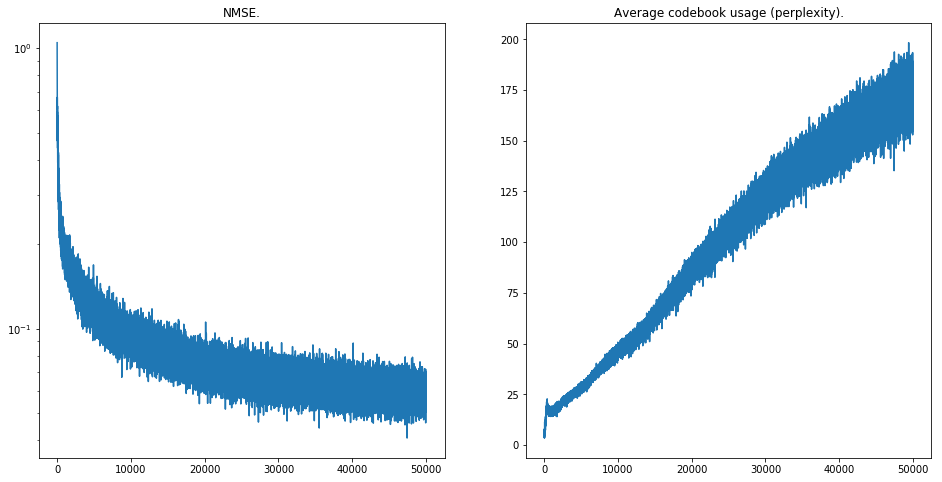

In [7]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error)
ax.set_yscale('log')
ax.set_title('NMSE.')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity)
ax.set_title('Average codebook usage (perplexity).')

### View reconstructions

W0701 06:18:16.149468 140267863771008 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0701 06:18:16.184010 140267863771008 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 127.5, -0.5)

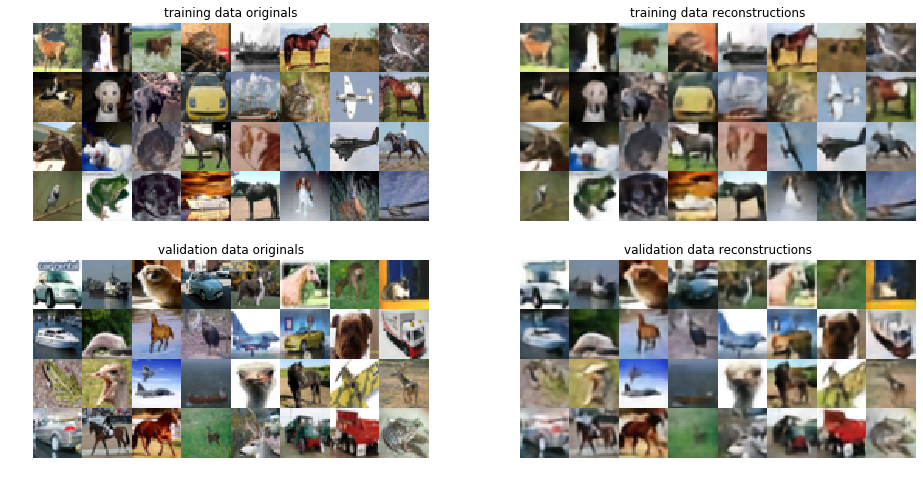

In [8]:

# Reconstructions
sess.run(valid_dataset_iterator.initializer)
train_originals = get_images(sess, subset='train')
train_reconstructions = sess.run(x_recon_eval, feed_dict={x: train_originals})
valid_originals = get_images(sess, subset='valid')
valid_reconstructions = sess.run(x_recon_eval, feed_dict={x: valid_originals})

def convert_batch_to_image_grid(image_batch):
  reshaped = (image_batch.reshape(4, 8, 32, 32, 3)
              .transpose(0, 2, 1, 3, 4)
              .reshape(4 * 32, 8 * 32, 3))
  return reshaped + 0.5



f = plt.figure(figsize=(16,8))
ax = f.add_subplot(2,2,1)
ax.imshow(convert_batch_to_image_grid(train_originals),
          interpolation='nearest')
ax.set_title('training data originals')
plt.axis('off')

ax = f.add_subplot(2,2,2)
ax.imshow(convert_batch_to_image_grid(train_reconstructions),
          interpolation='nearest')
ax.set_title('training data reconstructions')
plt.axis('off')

ax = f.add_subplot(2,2,3)
ax.imshow(convert_batch_to_image_grid(valid_originals),
          interpolation='nearest')
ax.set_title('validation data originals')
plt.axis('off')

ax = f.add_subplot(2,2,4)
ax.imshow(convert_batch_to_image_grid(valid_reconstructions),
          interpolation='nearest')
ax.set_title('validation data reconstructions')
plt.axis('off')